## Installation

```
pip install networkx python-louvain
```

In [1]:
# Dependendencies

!pip install networkx python-louvain

Processing c:\users\41789\appdata\local\pip\cache\wheels\c8\68\21\d04741956802581119d875a0d9fce6895e8f9ffae71223f3e3\python_louvain-0.15-py3-none-any.whl


You should consider upgrading via the 'C:\Users\41789\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import networkx as nx

import pandas as pd
from operator import itemgetter
import matplotlib.pyplot as plt
import collections
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman
import itertools
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
nx.__version__

'2.5'

## Introducting Networkx

NetworkX has a broad range of example networks that you can load with just a function call ([more examples here](https://networkx.github.io/documentation/stable/auto_examples/index.html)).

.. and a super friendly API that you can use to conviently build networks.

In order to get used to NetworkX API, let's just construct a simple **undirected graph**

### Creating and Visualizing a simple Undirected Graph

In [4]:
G = nx.Graph() # for a directed graph use nx.DiGraph()
G.add_node(1)
G.add_nodes_from(range(2,9))  # add multiple nodes at once

# add edges 
G.add_edge(1,2)
edges = [(2,3), (1,3), (4,1), (4,5), (5,6), (5,7), (6,7), (7,8), (6,8)]
G.add_edges_from(edges)
G.nodes()

NodeView((1, 2, 3, 4, 5, 6, 7, 8))

Did you like to get a quick overview of your dataset using `.describe()` in pandas ?
Here is the equivalent in NetworkX:

In [5]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 8
Number of edges: 10
Average degree:   2.5000


The library also has a built-in plotting engine (based on matplotlib).

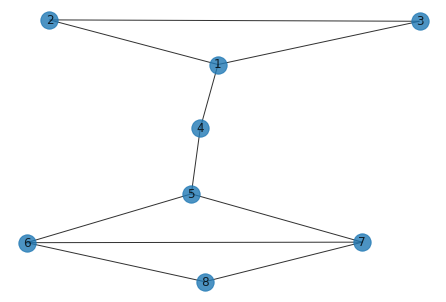

In [6]:
# plot it out
# for different layouts, please see: https://networkx.github.io/documentation/stable/reference/drawing.html#module-networkx.drawing.layout
nx.draw_spring(G, with_labels=True,  alpha = 0.8)

In [8]:
# Helper function for plotting the degree distribution of a Graph
def plot_degree_distribution(G):
    degrees = {}
    for node in G.nodes():
        degree = G.degree(node)
        if degree not in degrees:
            degrees[degree] = 0
        degrees[degree] += 1
    sorted_degree = sorted(degrees.items())
    deg = [k for (k,v) in sorted_degree]
    cnt = [v for (k,v) in sorted_degree]
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.ylabel("Frequency")
    plt.xlabel("Degree")
    ax.set_xticks([d+0.05 for d in deg])
    ax.set_xticklabels(deg)

In [9]:
# Helper function for printing various graph properties
def describe_graph(G):
    print(nx.info(G))
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

In [16]:
# Helper function for visualizing the graph
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o'):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='g', node_shape=node_shape)
    plt.axis('off')

### Creating and Visualizing an Erdős–Rényi graph

Name: 
Type: Graph
Number of nodes: 10
Number of edges: 20
Average degree:   4.0000
Avg. Shortest Path Length: 1.6000
Diameter: 3.0000
Sparsity: 0.4444
Global clustering coefficient aka Transitivity: 0.3649


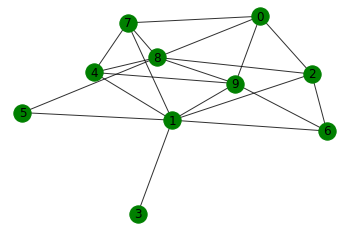

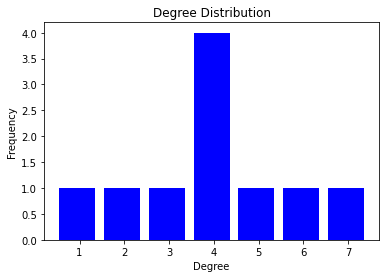

In [17]:
n = 10  # 10 nodes
m = 20  # 20 edges

erG = nx.gnm_random_graph(n, m)

describe_graph(erG)
visualize_graph(erG, k=0.05, alpha=0.8)
plot_degree_distribution(erG)

### Creating and Visualizing the Zachary's Karate Club Network

Name: Zachary's Karate Club
Type: Graph
Number of nodes: 34
Number of edges: 78
Average degree:   4.5882
Avg. Shortest Path Length: 2.4082
Diameter: 5.0000
Sparsity: 0.1390
Global clustering coefficient aka Transitivity: 0.2557


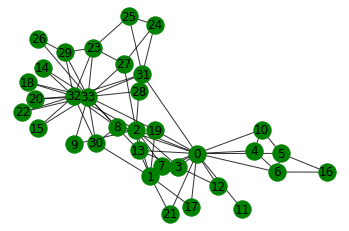

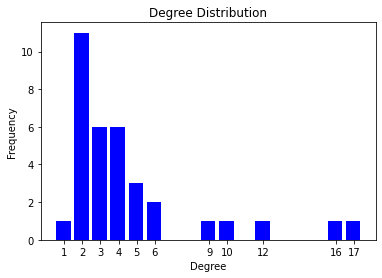

In [12]:
karateG = nx.karate_club_graph()
describe_graph(karateG)
visualize_graph(karateG, k=0.05, alpha=0.8)
plot_degree_distribution(karateG)

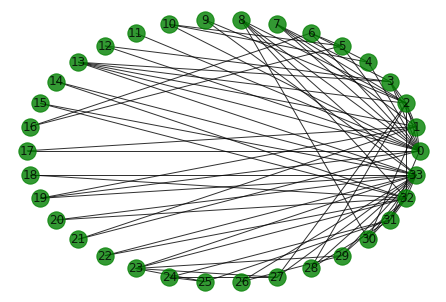

In [18]:
# Draw the graph with a circular layout instead?
nx.draw_circular(karateG, with_labels=True,  node_color='g', alpha = 0.8)

## Section 2: Quakers !

Let's now go beyond toy examples and load real data! 

England, in the mid-17th century. A novel group of Protestant Christians, called "Religious Society of Friends" dissent from the main doctrine. Their members are known as the "Quakers". This dataset is derived from the ["Oxford Dictionary of National Biography"](http://www.oxforddnb.com/) and from the ongoing work of the *"Six Degrees of Francis Bacon project"*, which is reconstructing the social networks of early modern Britain (1500-1700) to trace the personal relationships among figures like **Bacon**, **Shakespeare**, **Sir Isaac Newton** and many others.

[Credits](https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python)

### Meet the Quakers

In [19]:
data_folder = './data/quakers/'
nodes = pd.read_csv(data_folder + 'quakers_nodelist.csv')
nodes.head(10)

,Name,Historical Significance,Gender,Birthdate,Deathdate,ID
0,Joseph Wyeth,religious writer,male,1663,1731,10013191
1,Alexander Skene of Newtyle,local politician and author,male,1621,1694,10011149
2,James Logan,colonial official and scholar,male,1674,1751,10007567
3,Dorcas Erbery,Quaker preacher,female,1656,1659,10003983
4,Lilias Skene,Quaker preacher and poet,male,1626,1697,10011152
5,William Mucklow,religious writer,male,1630,1713,10008595
6,Thomas Salthouse,Quaker preacher and writer,male,1630,1691,10010643
7,William Dewsbury,Quaker activist,male,1621,1688,10003478
8,John Audland,Quaker preacher,male,1630,1664,10000411
9,Richard Claridge,Quaker minister and schoolmaster,male,1649,1723,10002469


In [24]:
nodes.Gender = nodes.Gender.astype('category')
nodes = nodes.rename({'Historical Significance': 'Role'}, axis = 1)
print('There are ', len(nodes), 'quakers')
nodes

There are  119 quakers


,Name,Role,Gender,Birthdate,Deathdate,ID
0,Joseph Wyeth,religious writer,male,1663,1731,10013191
1,Alexander Skene of Newtyle,local politician and author,male,1621,1694,10011149
2,James Logan,colonial official and scholar,male,1674,1751,10007567
3,Dorcas Erbery,Quaker preacher,female,1656,1659,10003983
4,Lilias Skene,Quaker preacher and poet,male,1626,1697,10011152
...,...,...,...,...,...,...
114,Thomas Ellwood,religious controversialist,male,1639,1713,10003945
115,William Simpson,Quaker preacher,male,1627,1671,10011114
116,Samuel Bownas,Quaker minister and writer,male,1677,1753,10001390
117,John Perrot,Quaker schismatic,male,1555,1665,10009584


In [21]:
nodes['Role'].isna().sum()

2

In [25]:
# some don't have a known 'historical significance' or 'role'
nodes['Role'].fillna('Unknown', inplace=True)

In [26]:
# check if the names are unique
len(nodes['Name'].unique()) == len(nodes)

True

In [27]:
# since the names are unique, index based on names
nodes.set_index('Name', inplace=True)

# let's also add a new attribute based on the role column. Is (s)he a directly involved Quaker or not? 
nodes['Quaker'] = ['quaker' in role.lower() for role in nodes.Role] # role.lower() met en lower case
nodes.head()

,Role,Gender,Birthdate,Deathdate,ID,Quaker
Name,,,,,,
Joseph Wyeth,religious writer,male,1663,1731,10013191,False
Alexander Skene of Newtyle,local politician and author,male,1621,1694,10011149,False
James Logan,colonial official and scholar,male,1674,1751,10007567,False
Dorcas Erbery,Quaker preacher,female,1656,1659,10003983,True
Lilias Skene,Quaker preacher and poet,male,1626,1697,10011152,True


In [28]:
# let's see which quaker knows whom, this will translate into edges in our graph
edges = pd.read_csv(data_folder + 'quakers_edgelist.csv')
edges.head()

,Source,Target
0,George Keith,Robert Barclay
1,George Keith,Benjamin Furly
2,George Keith,Anne Conway Viscountess Conway and Killultagh
3,George Keith,Franciscus Mercurius van Helmont
4,George Keith,William Penn


In [29]:
print('There are',len(edges), 'edges')

There are 174 edges


### The Quaker network

Now we have all the ingredients and more to translate this data into a network: nodes are the quakers and there exists an edge between two quakers if they know each other. Since being acquainted or friends is a symmetric relation, we will build an undirected graph.

Another bonus of NetworkX is the smooth integration with panda dataframes, which makes loading the network a one-liner.   
*Note: Only if you don't have isolated nodes*

In [30]:
quakerG =nx.from_pandas_edgelist(edges, 'Source', 'Target', edge_attr=None, create_using= nx.Graph())
describe_graph(quakerG)

Name: 
Type: Graph
Number of nodes: 119
Number of edges: 174
Average degree:   2.9244
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0248
Global clustering coefficient aka Transitivity: 0.1694


In [31]:
# add node attributes by passing dictionary of type name -> attribute
nx.set_node_attributes(quakerG, nodes['Role'].to_dict(), 'Role' )

In [32]:
nx.set_node_attributes(quakerG, nodes['Gender'].to_dict(), 'Gender' )
nx.set_node_attributes(quakerG, nodes['Birthdate'].to_dict(), 'Birthdate' )
nx.set_node_attributes(quakerG, nodes['Deathdate'].to_dict(), 'Deathdate' )
nx.set_node_attributes(quakerG, nodes['Quaker'].to_dict(), 'Quaker' )

In [33]:
# You can easily get the attributes of a node
quakerG.nodes['William Penn']

{'Role': 'Quaker leader and founder of Pennsylvania',
 'Gender': 'male',
 'Birthdate': 1644,
 'Deathdate': 1718,
 'Quaker': True}

### How connected is the quaker network ?  

To get a feel of the network, we could start by visually inspecting the graph. 

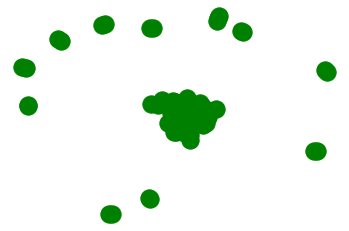

In [34]:
visualize_graph(quakerG, False, k=0.05, alpha=0.4)

Let's try to make the visualization a bit better...

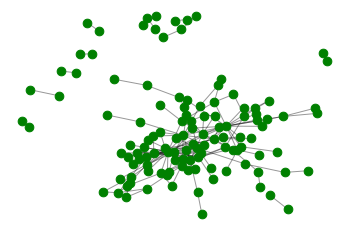

In [35]:
visualize_graph(quakerG, False, k=0.2, alpha=0.4, node_shape='.')

Still not a very pretty visualisation (.. install  [Gephy](https://gephi.org/) for some better-looking plots). However, a few things come across:

* The graph is not connected (there are a few isolated communities)
* There seem to be a few nodes with many connections (i.e. hubs)

That's as far as we can get, let's revert to **numbers and graph properties** for more insights!

### Sparsity
"Sparsity" of a graph with $n$ nodes is defined as follows: 

$ L = \frac{|E|}{|E_{max}|}$, where $E_{max} = \frac{n * (n-1)}{2}$

In [36]:
# 174 * (2) / ( 119* 118)
print("Network sparsity: %.4f" %nx.density(quakerG))

Network sparsity: 0.0248


### Connected Components
If the graph is not connected, how many "connected components" are there ?

In [38]:
print(nx.is_connected(quakerG))
comp = list(nx.connected_components(quakerG))
print('The graph contains', len(comp), 'connected components')

False
The graph contains 12 connected components


In [41]:
print(comp)

[{'Alexander Parker', 'Anne Conway Viscountess Conway and Killultagh', 'William Coddington', 'John Swinton', 'Lewis Morris', 'Charles Marshall', 'John Perrot', 'Benjamin Furly', 'Thomas Story', 'William Simpson', 'Ellis Hookes', 'David Barclay of Ury', 'David Lloyd', 'William Crouch', 'William Caton', 'Thomas Curtis', 'Alice Curwen', 'Franciscus Mercurius van Helmont', 'Anthony Sharp', 'James Claypoole', 'Thomas Aldam', 'Margaret Fell', 'Elizabeth Hooten', 'William Rogers', 'Edward Pyott', 'Edward Burrough', 'James Logan', 'Isaac Norris', 'John Audland', 'John Whitehead', 'Mary Penington', 'Gervase Benson', 'John Burnyeat', 'Thomas Camm', 'John Crook', 'Robert Rich', 'Stephen Crisp', 'George Keith', 'Leonard Fell', 'Samuel Fisher', 'Thomas Lawson', 'John Bartram', 'William Bradford', 'Francis Bugg', 'Henry Pickworth', 'Rebecca Travers', 'Daniel Quare', 'Dorcas Erbery', 'Hannah Stranger', 'William Mucklow', 'William Tomlinson', 'William Penn', 'William Mead', 'Silvanus Bevan', 'John ap 

In [44]:
largest_comp = max(comp, key=len)

percentage_lcc = len(largest_comp)/quakerG.number_of_nodes() * 100

print('The largest component has', len(largest_comp), 'nodes', 'accounting for %.2f'% percentage_lcc, '% of the nodes') 

The largest component has 96 nodes accounting for 80.67 % of the nodes


From visually inspecting the graph, we already saw that most of the nodes are in the largest component, which is often the case in a graph. That is why we usually call this component as a **giant component**.

### Diameter and Shortest Paths
Suppose I want to find the shortest path between two quakers, given that they are in the same connected component

In [45]:
fell_whitehead_path = nx.shortest_path(quakerG, source="Margaret Fell", target="George Whitehead")
print("Shortest path between Fell and Whitehead:", fell_whitehead_path)

Shortest path between Fell and Whitehead: ['Margaret Fell', 'George Fox', 'George Whitehead']


In [ ]:
# take the largest component and analyse its diameter = longest shortest-path
lcc_quakerG = quakerG.subgraph(largest_comp)
print("The diameter of the largest connected component is", nx.diameter(lcc_quakerG))
print("The avg shortest path length of the largest connected component is", nx.average_shortest_path_length(lcc_quakerG))

### A more social look at the network!

**Triadic Closure:**   
    A *friend* of my *friend* is my *friend*   
    OR   
    *quaker_1* knows *quaker_2* and *quaker_2* knows *quaker_3*, how likely is that *quaker_1* and *quaker_3* know each other?

Employ a **global** measure called **transitivity** (aka global clustering coefficient), or the ratio of all existing triangles (closed triples) over all possible triangles (open and closed triplets).

In [46]:
print('%.4f' %nx.transitivity(quakerG))

0.1694


Employ a **local** measure called **clustering coefficient**, which quantifies for a node how close its neighbours are to being a clique (complete graph). Measured as the ratio of, the number of edges to the number of all possible edges, among the neighbors of a node.

In [47]:
# Similar measure but for individual nodes called clustering coefficient
print(nx.clustering(quakerG, ['Alexander Parker', 'John Crook']))

{'Alexander Parker': 0.06666666666666667, 'John Crook': 0.8333333333333334}


In [48]:
# Lets check by looking at the subgraphs induced by Alex and John
subgraph_Alex = quakerG.subgraph(['Alexander Parker']+list(quakerG.neighbors('Alexander Parker')))
subgraph_John = quakerG.subgraph(['John Crook']+list(quakerG.neighbors('John Crook')))

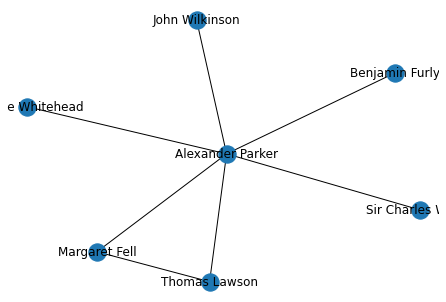

In [49]:
nx.draw_spring(subgraph_Alex, with_labels=True)

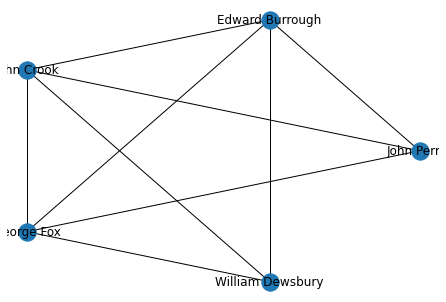

In [51]:
nx.draw_circular(subgraph_John, with_labels=True)

### Which quakers are the most important ?

As always, the answer is ... it depends. There are many ways to detect important nodes in a graph, for example based on:

* **Degree** (generalized by **Katz**)
* **Betweeness centrality**
* More ...

#### Degree: the more people you know, the more important you are!

In [52]:
degrees = dict(quakerG.degree(quakerG.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)

# And the top 5 most popular quakers are.. 
for quaker, degree in sorted_degree[:5]:
    print(quaker, 'who is', quakerG.nodes[quaker]['Role'], 'knows', degree, 'people')

George Fox who is  a founder of the Religious Society of Friends (Quakers) knows 22 people
William Penn who is Quaker leader and founder of Pennsylvania knows 18 people
James Nayler who is Quaker preacher and writer knows 16 people
George Whitehead who is Quaker leader and writer knows 13 people
Margaret Fell who is Quaker leader knows 13 people


Let's also analyze the *degree distribution*. 
We can see that most of the people know less than 5 quakers and there are some *leaders that are comparatively very popular*. 

Text(0.5, 1.0, 'Degree distribution for the Quaker network')

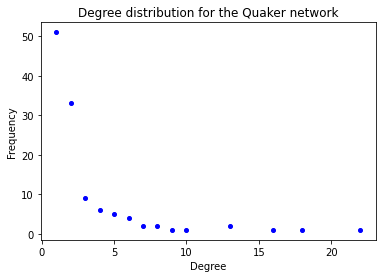

In [53]:
degree_seq = [d[1] for d in sorted_degree]
degreeCount = collections.Counter(degree_seq)
degreeCount = pd.DataFrame.from_dict( degreeCount, orient='index').reset_index()
fig = plt.figure()
ax = plt.gca()
ax.plot(degreeCount['index'], degreeCount[0], 'o', c='blue', markersize= 4)
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.title('Degree distribution for the Quaker network')

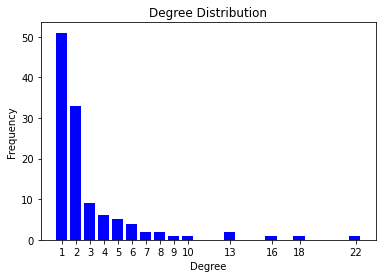

In [54]:
# As a bar plot
plot_degree_distribution(quakerG)

#### What about the Katz Centrality (the generalization over degree centrality)?

In [55]:
degrees = dict(quakerG.degree(quakerG.nodes()))

katz = nx.katz_centrality(quakerG)
nx.set_node_attributes(quakerG, katz, 'katz')
sorted_katz = sorted(katz.items(), key=itemgetter(1), reverse=True)

# And the top 5 most popular quakers are.. 
for quaker, katzc in sorted_katz[:5]:
    print(quaker, 'who is', quakerG.nodes[quaker]['Role'], 'has katz-centrality: %.3f' %katzc)

George Fox who is  a founder of the Religious Society of Friends (Quakers) has katz-centrality: 0.342
James Nayler who is Quaker preacher and writer has katz-centrality: 0.261
William Penn who is Quaker leader and founder of Pennsylvania has katz-centrality: 0.249
George Whitehead who is Quaker leader and writer has katz-centrality: 0.216
Margaret Fell who is Quaker leader has katz-centrality: 0.215


Note: this is an undirected graph. If you were to have a **directed** one, use separate metrics for **indegree** and **outdegree**.

#### Betweeness centrality: the more shortest paths pass through a node, the more important it is!

In [57]:
# Compute betweenness centrality
betweenness = nx.betweenness_centrality(quakerG)
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(quakerG, betweenness, 'betweenness')
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)

for quaker, bw in sorted_betweenness[:5]:
    print(quaker, 'who is', quakerG.nodes[quaker]['Role'], 'has betweeness: %.3f' %bw)

William Penn who is Quaker leader and founder of Pennsylvania has betweeness: 0.240
George Fox who is  a founder of the Religious Society of Friends (Quakers) has betweeness: 0.237
George Whitehead who is Quaker leader and writer has betweeness: 0.126
Margaret Fell who is Quaker leader has betweeness: 0.121
James Nayler who is Quaker preacher and writer has betweeness: 0.104


Let's analyze the betweeness centrality values for all the nodes in the network. As in the case with degree, there are a *few nodes with very high betweeness centrality*, while most of them have a low value.

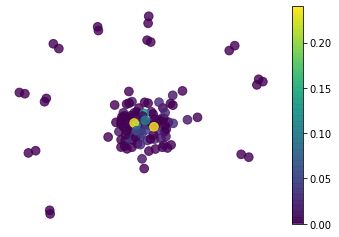

In [58]:
# similar pattern
list_nodes =list(quakerG.nodes())
list_nodes.reverse()   # for showing the nodes with high betweeness centrality 
pos = nx.spring_layout(quakerG)
ec = nx.draw_networkx_edges(quakerG, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(quakerG, pos, nodelist=list_nodes, node_color=[quakerG.nodes[n]["betweenness"] for n in list_nodes], 
                            alpha=0.8, node_shape = '.')
plt.colorbar(nc)
plt.axis('off')
plt.show()

At this point you might be tempted to think the measures are very similar, but let's revisit the original graph (G)

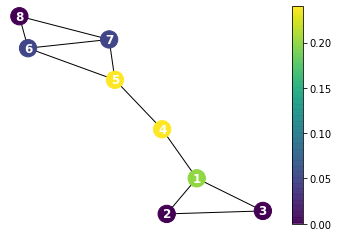

In [59]:
nx.set_node_attributes(G, nx.betweenness_centrality(G), 'betweenness')
pos = nx.spring_layout(G)
ec = nx.draw_networkx(G, pos, nodelist=G.nodes(),
                         node_color=[G.nodes[n]["betweenness"] for n in G.nodes()], 
                         node_shape = '.', node_size=1200, font_color="white", font_weight="bold")
plt.colorbar(nc)
plt.axis('off')
plt.show()

The node with the **lowest degree** is the one with the **highest betweeness centrality**. 

This concept also translates to edges. In particular, edge betweeness is the number of shortest paths that pass through an edge. This brings us to ...

### The quaker communities

Community detection is a common class of methods applied to graphs. 
Two important algorithms:
* **Girvan Newman**
* **Louvain**

#### Girvan Newman
**Idea:** Edges possessing high betweeness centrality separate communities. Let's apply this on our toy sample graph (G) to get a better understanding of the idea.

The algorithm starts with the entire graph and then it iteratively removes the edge with the highest betweeness.

In [60]:
comp = girvan_newman(G)
it = 0
for communities in itertools.islice(comp, 4):
    it +=1
    print('Iteration', it)
    print(tuple(sorted(c) for c in communities)) 

Iteration 1
([1, 2, 3, 4], [5, 6, 7, 8])
Iteration 2
([1, 2, 3], [4], [5, 6, 7, 8])
Iteration 3
([1, 2, 3], [4], [5], [6, 7, 8])
Iteration 4
([1], [2, 3], [4], [5], [6, 7, 8])


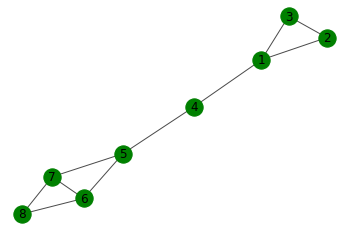

In [61]:
visualize_graph(G,alpha=0.7)

#### The [Louvain method](https://en.wikipedia.org/wiki/Louvain_Modularity)

Another clustering algorithm and has become a standard algorithm in the data scientist toolbox.   
**Idea:** It proceeds the other way around: initially every node is considered as a community. The communities are traversed, and for each community it is tested whether by joining it to a neighboring community, we can obtain a better clustering. 

In [62]:
partition = community_louvain.best_partition(quakerG)
# add it as an attribute to the nodes
for n in quakerG.nodes:
    quakerG.nodes[n]["louvain"] = partition[n]

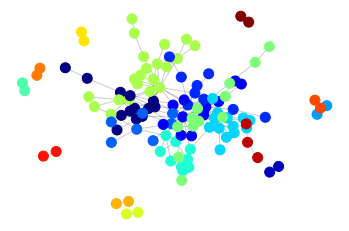

In [63]:
# plot it out
pos = nx.spring_layout(quakerG,k=0.2)
ec = nx.draw_networkx_edges(quakerG, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(quakerG, pos, nodelist=quakerG.nodes(), node_color=[quakerG.nodes[n]["louvain"] for n in quakerG.nodes], 
                            node_size=100, cmap=plt.cm.jet)
plt.axis('off')
plt.show()

Let's get a closer look at a few clusters and show their member's role and period in which they lived

In [64]:
cluster_James = partition['James Nayler']
# Take all the nodes that belong to James' cluster
members_c = [q for q in quakerG.nodes if partition[q] == cluster_James]
# get info about these quakers
for quaker in members_c:
    print(quaker, 'who is', quakerG.nodes[quaker]['Role'], 'and died in ',quakerG.nodes[quaker]['Deathdate'])

Dorcas Erbery who is Quaker preacher and died in  1659
James Nayler who is Quaker preacher and writer and died in  1660
Francis Howgill who is Quaker activist and died in  1669
Martha Simmonds who is Quaker and author and died in  1665
Richard Farnworth who is Quaker preacher and writer and died in  1666
William Crouch who is Quaker leader and writer and died in  1711
Hannah Stranger who is Quaker missionary and died in  1671
Gervase Benson who is Quaker leader and died in  1679
Robert Rich who is Quaker adherent and sectary and died in  1679
Anthony Pearson who is Quaker administrator and died in  1666
William Tomlinson who is religious writer and died in  1696
Richard Hubberthorne who is Quaker activist and died in  1662
Thomas Aldam who is Quaker preacher and writer and died in  1660


In [65]:
cluster_Lydia = partition['Lydia Lancaster']
# Take all the nodes that belong to Lydia's cluster
members_c = [q for q in quakerG.nodes if partition[q] == cluster_Lydia]
# get info about these quakers
for quaker in members_c:
    print(quaker, 'who is', quakerG.nodes[quaker]['Role'], 'and died in ',quakerG.nodes[quaker]['Deathdate'])

Lydia Lancaster who is Quaker minister and died in  1761
Grace Chamber who is Quaker minister and died in  1762


### Homophily in quakers 
How likely is it that two quakers who have the same attribute are linked?

Try to measure the similarity of connections in the graph with respect to a given attribute.   
*Intuition: Like correlation, but translated to graphs.*

In [66]:
# for categorical attributes
nx.attribute_assortativity_coefficient(quakerG, 'Gender')

0.1882377889305155

In [67]:
nodes.groupby('Gender').size()

Gender
female    22
male      97
dtype: int64

There is no notion of *gender homophily* in this network, which makes sense due to the following:
* Couples
* Gender imbalance

However, there exists **age homophily**: quakers that died in the same period are more likely to be linked

In [68]:
# for numerical attributes, values must be integers
nx.numeric_assortativity_coefficient(quakerG, 'Deathdate')

0.5841284189313894

### Few Exercises
1. Visually determine the diameter of the small graph we built at the beginning (G) and then check you got it right.
2. Experiment with the Girvan Newman algorithm on the Quaker (quakerG) network.
3. Compute role homophily in the Quaker network.   
*Hint: You can either do it based on the given roles you have or develop a more coarse categorisation of roles and repeat your analysis after.*

### Take it further 
Course at Stanford taught by Jure Leskovec: http://web.stanford.edu/class/cs224w/

(Better) alternative to NetworkX, see igraph: http://igraph.org/python/

For larger graph analysis:

* Apache GraphX: https://spark.apache.org/graphx/
* Apache Giraph: http://giraph.apache.org
* Webgraph: http://webgraph.di.unimi.it/
* SNAP: http://snap.stanford.edu/snap/
* Graph tool: https://graph-tool.skewed.de
* Network kit: https://networkit.iti.kit.edu/api/structures.html
* Pajek: http://mrvar.fdv.uni-lj.si/pajek/
* Network Workbench: http://nwb.cns.iu.edu